In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from matplotlib.lines import Line2D
from pathlib import Path

In [2]:
plt.style.use('science')

In [3]:
date = "2023-03-14-22-37-07"
experiment = "hatexplain-lime-distilbert-2"

here_path = Path().absolute()
experiments_path = here_path.parent / "data" / "experiments"
experiment_path = experiments_path / date / experiment
results_path = experiment_path / "results.jsonl"

In [4]:
results = []
with open(results_path, 'r') as f:
    for line in f:
        results.append(json.loads(line))

In [5]:
results = sorted(results, key=lambda x: x['weight'], reverse=True)
results = results[:-1]
weights = [result['weight'] for result in results]
accuracies = [result['performance']['accuracy'] for result in results]
grid = []
filter_grid = []
for result in results:
    filtered_result = [el for el in result['explainability']['alternative_auprc'] if el is not None and not np.isnan(el)]
    filter = [1 if el is not None and not np.isnan(el) else 0 for el in result['explainability']['alternative_auprc']]
    grid.append(filtered_result)
    filter_grid.append(filter)
assert set(np.mean(filter_grid, axis=0)) == {0, 1}  # Therefore we can use the same filter in all models
grid = np.array(grid)
bad = grid[:, grid[0] != 1.0].mean(axis=1)
good = grid[:, grid[0] == 1.0].mean(axis=1)

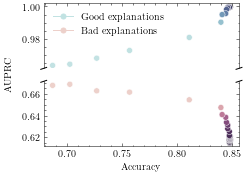

In [6]:
w1 = weights

fig, axes = plt.subplots(2, 1, sharex=True)

x = accuracies
y = good
sns.scatterplot(
    x="Accuracy",
    y="AUPRC",
    data=pd.DataFrame({
        "Accuracy": x,
        "AUPRC": y,
    }),
    hue=w1,
    ax=axes[0],
    palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
)

x = accuracies
y = bad
sns.scatterplot(
    x="Accuracy",
    y="AUPRC",
    data=pd.DataFrame({
        "Accuracy": x,
        "AUPRC": y,
    }),
    hue=w1,
    ax=axes[1],
)
axes[0].get_legend().remove()
axes[1].get_legend().remove()

axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop=False)  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()

d = .015
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=axes[1].transAxes)
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

axes[0].yaxis.set_label_coords(-0.16, -0.1)
axes[1].set_ylabel("")

legend_elements = [
    Line2D([0], [0], marker='o', \
        color=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)(1), \
            label='Good explanations', markersize=5),
    Line2D([0], [0], marker='o', \
        color=sns.cubehelix_palette(as_cmap=True)(1), \
            label='Bad explanations', markersize=5),
]

axes[0].legend(handles=legend_elements, loc='upper left')

plt.savefig("sample_level_auprc.pdf", dpi=300, bbox_inches="tight")

In [7]:
best = np.argmax(grid.mean(axis=1))
print(best, weights[best], accuracies[best], grid[best].mean())

23 0.19537185696468617 0.8396363636363636 0.821847995830308


In [8]:
print(bad[best], bad[0])
print(bad[best] - bad[0])
print(bad[best]/bad[0])

0.6473150322669033 0.6146781183678323
0.032636913899071085
1.0530959422888397


In [9]:
print(good[best], good[0])
print(good[best] - good[0])
print(good[best]/good[0])

0.9902621075826418 1.0
-0.00973789241735823
0.9902621075826418


In [10]:
(grid[0] == 1.0).mean()

0.5089209855564996